## 1. Creating the world:

In [13]:
import numpy as np
from utils import make_data

# world parameters
num_landmarks      = 5        # number of landmarks
N                  = 20       # time steps
world_size         = 100.0    # size of world (square)

# robot parameters
measurement_range  = 50.0     # range at which we can sense landmarks
motion_noise       = 2.0      # noise in robot motion
measurement_noise  = 2.0      # noise in the measurements
distance           = 20.0     # distance by which robot (intends to) move each iteratation 


# make_data instantiates a robot, AND generates random landmarks for a given world size and number of landmarks
data = make_data(N, num_landmarks, world_size, measurement_range, motion_noise, measurement_noise, distance)

 
Landmarks:  [[2, 64], [44, 96], [22, 72], [38, 81], [43, 13]]
Robot: [x=14.70870 y=80.58020]


In [2]:
# print out some stats about the data
time_step = 0

print('Example measurements: \n', data[time_step][0])
print('\n')
print('Example motion: \n', data[time_step][1])

Example measurements: 
 [[0, -34.211093204951595, 60.95104293827838]]


Example motion: 
 [12.644906424941489, 15.495365162024207]


## 2. Initialize constraints:

In [3]:
def initialize_constraints(N, num_landmarks, world_size):
    ''' This function takes in a number of time steps N, number of landmarks, and a world_size,
        and returns initialized constraint matrices, omega and xi.'''
    
    size = 2*(N+num_landmarks)
    omega = np.zeros((size, size)) 
    omega[0][0], omega[1][1] = 1, 1
    
    xi = np.zeros((size, 1))
    xi[0], xi[1] = world_size/2, world_size/2

    return omega, xi
    

In [4]:
# import data viz resources
import matplotlib.pyplot as plt
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

In [5]:
N_test = 5
num_landmarks_test = 2
small_world = 10

# initialize the constraints
initial_omega, initial_xi = initialize_constraints(N_test, num_landmarks_test, small_world)

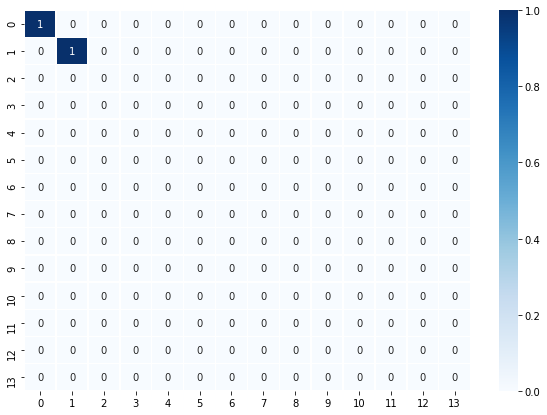

In [6]:
# define figure size
plt.rcParams["figure.figsize"] = (10,7)

# display omega
sns.heatmap(DataFrame(initial_omega), cmap='Blues', annot=True, linewidths=.5)

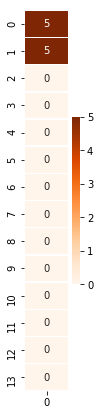

In [7]:
# define  figure size
plt.rcParams["figure.figsize"] = (1,7)

# display xi
sns.heatmap(DataFrame(initial_xi), cmap='Oranges', annot=True, linewidths=.5)

## 3. Graph SLAM implementation:

In [8]:

## slam takes in 6 arguments and returns mu, 
## mu is the entire path traversed by a robot (all x,y poses) *and* all landmarks locations
def slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise):
    
    omega, xi = initialize_constraints(N, num_landmarks, world_size)
    print("landmarks = {0}, omega dimension = {1}".format(num_landmarks, omega.shape))
    
    
    ## get all the motion and measurement data as you iterate 
    for t in range(len(data)):
        measurements, motion = data[t][0], data[t][1]
        i = 2*t
    
        omega[i][i] +=  1.0/motion_noise     
        omega[i+1][i+1] +=  1.0/motion_noise     
        omega[i][i+2] += -1.0/motion_noise    
        omega[i+1][i+3] += -1.0/motion_noise     
        omega[i+2][i] += -1.0/motion_noise    
        omega[i+3][i+1] += -1.0/motion_noise     
        omega[i+2][i+2] +=  1.0/motion_noise     
        omega[i+3][i+3] +=  1.0/motion_noise     

        xi[i] += -1.0/motion_noise   * motion[0]
        xi[i+1] += -1.0/motion_noise   * motion[1]
        xi[i+2] +=  1.0/motion_noise   * motion[0]
        xi[i+3] +=  1.0/motion_noise   * motion[1]
    
    
        for m in measurements:
            omega[i][i] +=  1.0/measurement_noise   
            omega[i+1][i+1] +=  1.0/measurement_noise   
            omega[i][2*(N+m[0])] += -1.0/measurement_noise   
            omega[i+1][2*(N+m[0]) + 1] += -1.0/measurement_noise   
            omega[2*(N+m[0])][i] += -1.0/measurement_noise  
            omega[2*(N+m[0]) + 1][i+1] += -1.0/measurement_noise  
            omega[2*(N+m[0])][2*(N+m[0])] +=  1.0/measurement_noise   
            omega[2*(N+m[0]) + 1][2*(N+m[0]) + 1] +=  1.0/measurement_noise 

            try:
                xi[i] += -m[1]*1.0/measurement_noise
                xi[i+1] += -m[2]*1.0/measurement_noise
                xi[2*(N+m[0])] +=  m[1]*1.0/measurement_noise
                xi[2*(N+m[0])+1] +=  m[2]*1.0/measurement_noise

            except IndexError:
                pass
            
    mu = np.dot(np.linalg.inv(omega), xi)
    
    return mu 


In [9]:
# a function creates a list of poses and of landmarks for ease of printing
def get_poses_landmarks(mu, N):
    # create a list of poses
    poses = []
    for i in range(N):
        poses.append((mu[2*i].item(), mu[2*i+1].item()))

    # create a list of landmarks
    landmarks = []
    for i in range(num_landmarks):
        landmarks.append((mu[2*(N+i)].item(), mu[2*(N+i)+1].item()))

    # return completed lists
    return poses, landmarks


In [10]:
def print_all(poses, landmarks):
    print('\n')
    print('Estimated Poses:')
    for i in range(len(poses)):
        print('['+', '.join('%.3f'%p for p in poses[i])+']')
    print('\n')
    print('Estimated Landmarks:')
    for i in range(len(landmarks)):
        print('['+', '.join('%.3f'%l for l in landmarks[i])+']')


In [11]:
mu = slam(data, N, num_landmarks, world_size, motion_noise, measurement_noise)

if(mu is not None):
    poses, landmarks = get_poses_landmarks(mu, N)
    print_all(poses, landmarks)

landmarks = 5, omega dimension = (50, 50)


Estimated Poses:
[50.000, 50.000]
[61.995, 66.303]
[69.471, 48.835]
[64.417, 29.973]
[44.343, 30.170]
[24.124, 29.858]
[2.610, 30.076]
[-18.155, 30.825]
[1.100, 34.057]
[20.879, 37.958]
[40.344, 41.659]
[58.645, 46.000]
[67.133, 28.430]
[47.947, 28.329]
[28.121, 28.747]
[7.270, 27.893]
[25.115, 32.262]
[43.770, 35.589]
[63.435, 39.192]
[59.306, 58.762]


Estimated Landmarks:
[16.439, 110.144]
[-1.194, 38.811]
[66.868, 63.565]
[3.872, 33.959]
[47.828, 36.437]


In [15]:
from utils import display_world


plt.rcParams["figure.figsize"] = (20,20)

if 'poses' in locals():
    print('Last pose: ', poses[-1])
    display_world(int(world_size), poses[-1], landmarks)

Last pose:  (59.30614488015207, 58.76157262187098)


NameError: name 'np' is not defined